# FastText Experimenty

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '../Data/wiki-news-300d-1M.vec.zip'

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM, GRU


In [ ]:
dataset = pd.read_csv('../Data/final_dataset_4.csv')

## Split datasetu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoder

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
y_test.shape

(242, 20)

## Embdding matica

In [ ]:
embeddings_index = {}
with open('wiki-news-300d-1M.vec') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 999995 word vectors.


In [ ]:
embedding_dim = 300
vocab_size = 80000
sequence_length = 9000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X_train.values)

In [ ]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 50204 words (29796 misses)


# Modely

## DNN model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.GlobalAveragePooling1D()(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
output_layer =  keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 9000, 300)         24000600  
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1024)              308224

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/10
28/28 [==============================] - 153s 6s/step - loss: 2.9456 - accuracy: 0.0677 - val_loss: 2.9048 - val_accuracy: 0.0928
Epoch 2/10
28/28 [==============================] - 147s 5s/step - loss: 2.7881 - accuracy: 0.1699 - val_loss: 2.6630 - val_accuracy: 0.2474
Epoch 3/10
28/28 [==============================] - 148s 5s/step - loss: 2.4553 - accuracy: 0.2870 - val_loss: 2.3184 - val_accuracy: 0.3505
Epoch 4/10
28/28 [==============================] - 146s 5s/step - loss: 2.0559 - accuracy: 0.3559 - val_loss: 2.0940 - val_accuracy: 0.2680
Epoch 5/10
28/28 [==============================] - 146s 5s/step - loss: 1.8042 - accuracy: 0.4305 - val_loss: 1.8598 - val_accuracy: 0.4124
Epoch 6/10
28/28 [==============================] - 144s 5s/step - loss: 1.5783 - accuracy: 0.5247 - val_loss: 1.6293 - val_accuracy: 0.5773
Epoch 7/10
28/28 [==============================] - 146s 5s/step - loss: 1.4243 - accuracy: 0.5775 - val_loss: 1.5402 - val_accuracy: 0.5670
Epoch 8/10
28

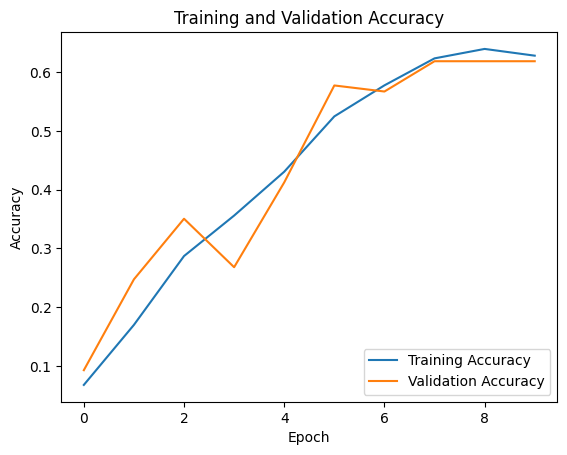

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 52ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6859504132231405
F1 Score: 0.661472636658701
Precision: 0.6805787865917909
Recall: 0.6859504132231405


## CNN Model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(emb)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 9000, 300)         24000600  
                                                                 
 conv1d (Conv1D)             (None, 8997, 512)         614912    
                                                                 
 max_pooling1d (MaxPooling1  (None, 4498, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d_1  (None, 512)               0   

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
28/28 [==============================] - 162s 6s/step - loss: 2.9409 - accuracy: 0.0551 - val_loss: 2.8863 - val_accuracy: 0.0412
Epoch 2/15
28/28 [==============================] - 152s 6s/step - loss: 2.8093 - accuracy: 0.1355 - val_loss: 2.7457 - val_accuracy: 0.1856
Epoch 3/15
28/28 [==============================] - 151s 6s/step - loss: 2.5973 - accuracy: 0.2767 - val_loss: 2.4764 - val_accuracy: 0.2062
Epoch 4/15
28/28 [==============================] - 151s 6s/step - loss: 2.2797 - accuracy: 0.3387 - val_loss: 2.1732 - val_accuracy: 0.3093
Epoch 5/15
28/28 [==============================] - 150s 6s/step - loss: 2.0007 - accuracy: 0.4466 - val_loss: 1.8915 - val_accuracy: 0.4948
Epoch 6/15
28/28 [==============================] - 149s 6s/step - loss: 1.7664 - accuracy: 0.4983 - val_loss: 1.7368 - val_accuracy: 0.4536
Epoch 7/15
28/28 [==============================] - 149s 6s/step - loss: 1.5804 - accuracy: 0.5442 - val_loss: 1.6362 - val_accuracy: 0.5361
Epoch 8/15
28

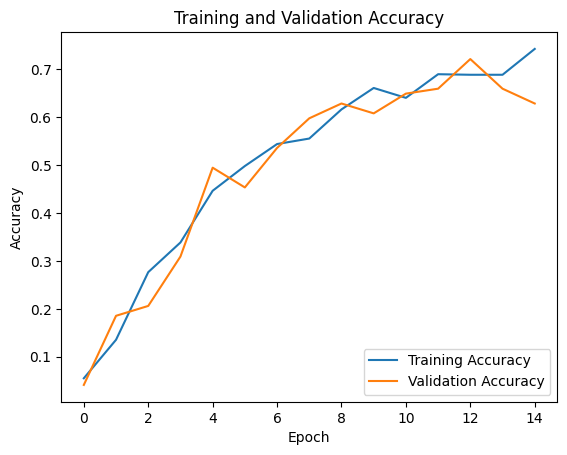

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 138ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7520661157024794
F1 Score: 0.7424850737635068
Precision: 0.8005483338705264
Recall: 0.7520661157024794


## Biderectional LSTMU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 9000, 300)         24000600  
                                                                 
 bidirectional (Bidirection  (None, 9000, 256)         439296    
 al)                                                             
                                                                 
 global_average_pooling1d_2  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
28/28 [==============================] - 164s 6s/step - loss: 2.9469 - accuracy: 0.0689 - val_loss: 2.8984 - val_accuracy: 0.0619
Epoch 2/15
28/28 [==============================] - 158s 6s/step - loss: 2.7717 - accuracy: 0.1079 - val_loss: 2.7409 - val_accuracy: 0.0722
Epoch 3/15
28/28 [==============================] - 158s 6s/step - loss: 2.5782 - accuracy: 0.1470 - val_loss: 2.4550 - val_accuracy: 0.1443
Epoch 4/15
28/28 [==============================] - 19s 670ms/step - loss: 2.4212 - accuracy: 0.1940 - val_loss: 2.4832 - val_accuracy: 0.1753
Epoch 5/15
28/28 [==============================] - 160s 6s/step - loss: 2.1784 - accuracy: 0.2882 - val_loss: 2.1883 - val_accuracy: 0.3299
Epoch 6/15
28/28 [==============================] - 162s 6s/step - loss: 1.9457 - accuracy: 0.3685 - val_loss: 2.0491 - val_accuracy: 0.3402
Epoch 7/15
28/28 [==============================] - 160s 6s/step - loss: 1.8386 - accuracy: 0.3812 - val_loss: 1.9026 - val_accuracy: 0.3918
Epoch 8/15


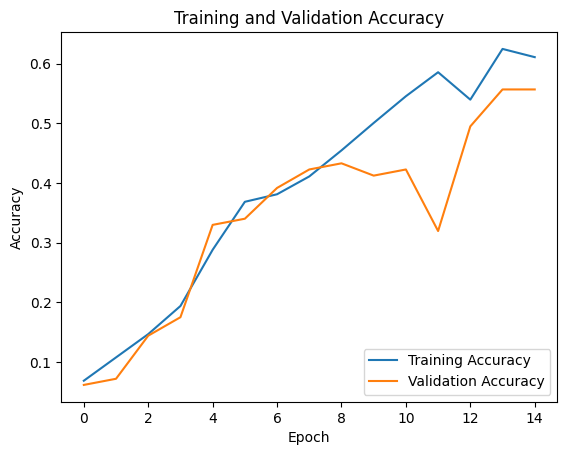

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 3s 266ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6900826446280992
F1 Score: 0.6814038801900589
Precision: 0.6988362026889008
Recall: 0.6900826446280992


## LSTM + GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 9000, 300)         24000600  
                                                                 
 lstm_1 (LSTM)               (None, 9000, 256)         570368    
                                                                 
 dropout_5 (Dropout)         (None, 9000, 256)         0         
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
28/28 [==============================] - 169s 6s/step - loss: 2.9680 - accuracy: 0.0563 - val_loss: 2.9606 - val_accuracy: 0.0515
Epoch 2/15
28/28 [==============================] - 163s 6s/step - loss: 2.8948 - accuracy: 0.0654 - val_loss: 2.9105 - val_accuracy: 0.0825
Epoch 3/15
28/28 [==============================] - 164s 6s/step - loss: 2.8460 - accuracy: 0.0953 - val_loss: 2.8859 - val_accuracy: 0.0722
Epoch 4/15
28/28 [==============================] - 24s 845ms/step - loss: 2.7827 - accuracy: 0.1079 - val_loss: 2.8867 - val_accuracy: 0.0722
Epoch 5/15
28/28 [==============================] - 164s 6s/step - loss: 2.7384 - accuracy: 0.1160 - val_loss: 2.8636 - val_accuracy: 0.1031
Epoch 6/15
28/28 [==============================] - 163s 6s/step - loss: 2.6693 - accuracy: 0.1401 - val_loss: 2.8299 - val_accuracy: 0.1340
Epoch 7/15
28/28 [==============================] - 24s 851ms/step - loss: 2.5870 - accuracy: 0.1515 - val_loss: 2.8413 - val_accuracy: 0.1031
Epoch 8/1

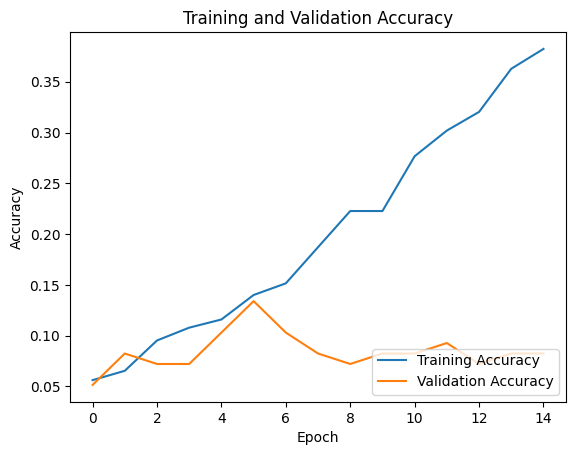

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 3s 339ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.0743801652892562
F1 Score: 0.05147149526189889
Precision: 0.06247589443991972
Recall: 0.0743801652892562
